# Sparkify Project Workspace - Part 2

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

In [3]:
import sys
sys.path.append('src/')

import util

In [4]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify_modelling_v2") \
        .getOrCreate()

In [5]:
user_dataset = "spark_user_data.csv"

df = spark.read.csv(user_dataset, header=True, inferSchema=True)

In [6]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- num_songs: integer (nullable = true)
 |-- num_songs_unique: integer (nullable = true)
 |-- num_artist: integer (nullable = true)
 |-- total_play_length: double (nullable = true)
 |-- num_active_days: integer (nullable = true)
 |-- date_from: string (nullable = true)
 |-- date_to: string (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- num_active_days_paid: double (nullable = true)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- Cancel: double (nullable = true)
 |-- Cancellation Confirmation: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Login: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: integer (nullable = true)
 |-- Register: double (nullable = true)
 |-- Roll Advert:

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### These classifiers are considered.

- Logistic Regression
- Decision Tree
- K-Nearest Neighbors

In [7]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler

In [8]:
# Initially selected feature columns

feature_cols = \
['num_songs',
 'num_artist',
 'num_active_days',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Thumbs Up',
 'days_since_registration',
 'avg_songs_per_active_day',
 'avg_play_length_per_active_day']

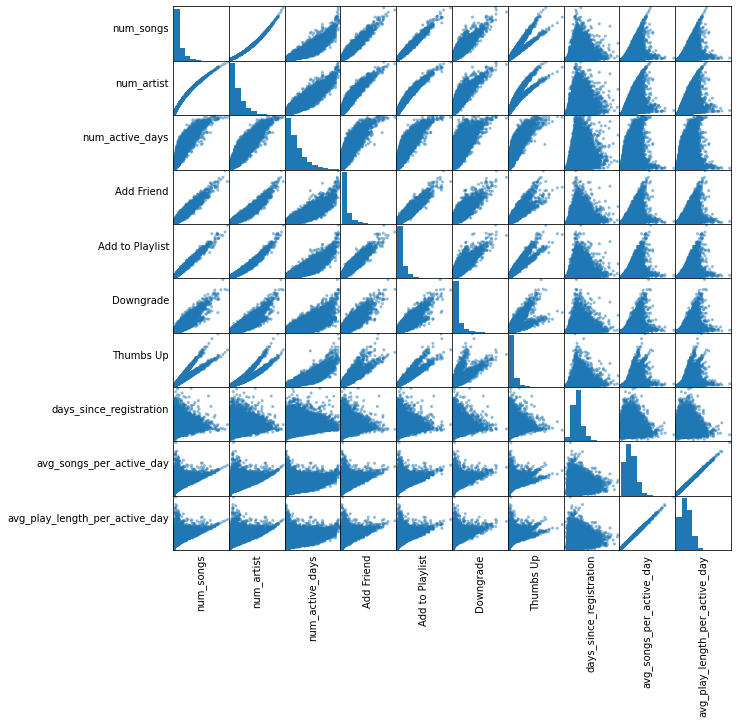

In [9]:
# Try avoiding correlated variables by creating scatter matrix. 

import pandas as pd
from pandas.plotting import scatter_matrix

numeric_data = df.select(feature_cols).toPandas()

axs = scatter_matrix(numeric_data, figsize=(10, 10));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [10]:
# We decide to use the following variables as features to be used in ML process later.

feature_cols = \
['num_active_days',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Thumbs Up',
 'days_since_registration',
 'avg_songs_per_active_day']

In [11]:
# Prepare pipeline tranformation methods

vectorAssembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features')
v_df = vectorAssembler.transform(df)

scaler = Normalizer(inputCol="features", outputCol="ScaledFeatures")
v_df = scaler.transform(v_df)

scaler2 = StandardScaler(inputCol="ScaledFeatures", outputCol="ScaledFeatures2", withStd=True)
scalerModel = scaler2.fit(v_df)

v_df = scalerModel.transform(v_df)

In [12]:
# define 'feature' and 'label' columns

v_df = v_df.select(v_df.churn, v_df.ScaledFeatures2) \
        .withColumn('label', v_df.churn) \
        .withColumn('features', v_df.ScaledFeatures2)

In [13]:
# Split training and testing dataset

splits = v_df.randomSplit([0.8, 0.2], seed=42)
train_df = splits[0]
test_df  = splits[1]

In [14]:
# Use Logistic Regression Model to traing data.

lr = LogisticRegression(featuresCol = 'features', labelCol='label')
lr_model = lr.fit(train_df)

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept:    " + str(lr_model.intercept))

Coefficients: [0.41447991228529485,-0.05133494164780514,-0.12829546579950554,0.36983672937825024,-1.1006264884670682,-0.9645051224316084,0.20490105615569434]
Intercept:    1.5561679152595738


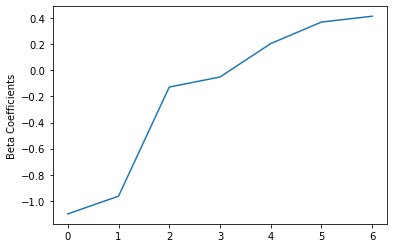

In [15]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lr_model.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

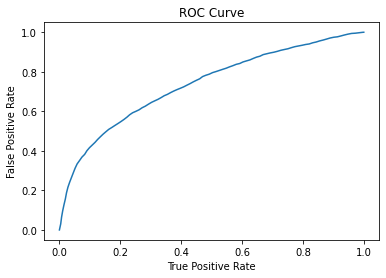

Training set areaUnderROC: 0.7351911960075196


In [16]:
trainingSummary = lr_model.summary

roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

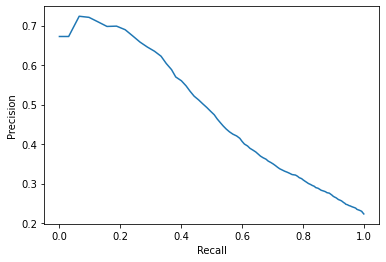

In [17]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

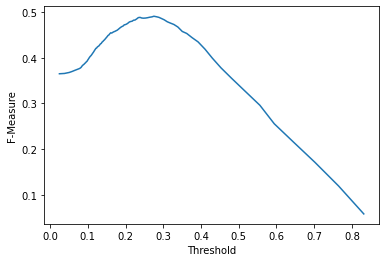

In [18]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [19]:
lr_predictions = lr_model.transform(test_df)

lr_predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[2.49417163551527...|       0.0|[0.92373221857006...|
|    0|[2.47957961088339...|       0.0|[0.92269781828387...|
|    0|[2.35481797669637...|       0.0|[0.91331642487332...|
|    0|[2.30263562107538...|       0.0|[0.90909508487908...|
|    0|[2.33762112468591...|       0.0|[0.91194524593810...|
|    0|[2.42868391271676...|       0.0|[0.91898860601067...|
|    0|[2.46070530474617...|       0.0|[0.92134079282247...|
|    0|[2.41347526573832...|       0.0|[0.91784910510524...|
|    0|[2.41906663277062...|       0.0|[0.91826972225940...|
|    0|[2.43312271136321...|       0.0|[0.91931845412980...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

print('Test Area Under ROC', evaluator.evaluate(lr_predictions))

Test Area Under ROC 0.7407260800231313


In [28]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

lr_cv_model = lr_cv.fit(train_df)
lr_cv_predictions = lr_cv_model.transform(test_df)
print('Test Area Under ROC', evaluator.evaluate(lr_cv_predictions))

Test Area Under ROC 0.7310203946549035


In [35]:
matched = lr_cv_predictions.filter(lr_cv_predictions.label == lr_cv_predictions.prediction).count()
total = lr_cv_predictions.count()
print("Logistic Regression CV - Accuracy : {}".format(matched/total) )

Logistic Regression CV - Accuracy : 0.793369663941871


### Use Decision Tree Classifier

In [62]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol='label', maxDepth=2)
dt_model = dt.fit(train_df)

dt_predictions = dt_model.transform(test_df)
dt_predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+----------------+----------+--------------------+
|label|   rawPrediction|prediction|         probability|
+-----+----------------+----------+--------------------+
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
|    0|[12053.0,2436.0]|       0.0|[0.83187245496583...|
+-----+----------------+----------+--------------------+
only showing top 10 rows



In [64]:
dt_evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.3597989768851288


### Use Random Forest Classifier

In [40]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)
rf_predictions.select('rawPrediction', 'prediction', 'probability').show(10)

+--------------------+----------+--------------------+
|       rawPrediction|prediction|         probability|
+--------------------+----------+--------------------+
|[17.3897642988627...|       0.0|[0.86948821494313...|
|[17.3897642988627...|       0.0|[0.86948821494313...|
|[17.3897642988627...|       0.0|[0.86948821494313...|
|[17.3897642988627...|       0.0|[0.86948821494313...|
|[17.3897642988627...|       0.0|[0.86948821494313...|
|[17.3897642988627...|       0.0|[0.86948821494313...|
|[17.3897642988627...|       0.0|[0.86948821494313...|
|[17.3897642988627...|       0.0|[0.86948821494313...|
|[17.3897642988627...|       0.0|[0.86948821494313...|
|[17.3897642988627...|       0.0|[0.86948821494313...|
+--------------------+----------+--------------------+
only showing top 10 rows



In [41]:
rf_evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(rf_evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7412871064940012


### Use Gradient-boosted Tree Classifier

In [42]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('rawPrediction', 'prediction', 'probability').show(10)

+--------------------+----------+--------------------+
|       rawPrediction|prediction|         probability|
+--------------------+----------+--------------------+
|[0.83051882854711...|       0.0|[0.84037724700181...|
|[0.83051882854711...|       0.0|[0.84037724700181...|
|[0.83051882854711...|       0.0|[0.84037724700181...|
|[0.82597001247131...|       0.0|[0.83915307798095...|
|[0.83051882854711...|       0.0|[0.84037724700181...|
|[0.83051882854711...|       0.0|[0.84037724700181...|
|[0.83051882854711...|       0.0|[0.84037724700181...|
|[0.83051882854711...|       0.0|[0.84037724700181...|
|[0.83051882854711...|       0.0|[0.84037724700181...|
|[0.83051882854711...|       0.0|[0.84037724700181...|
+--------------------+----------+--------------------+
only showing top 10 rows



In [51]:
gbt_evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(gbt_evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.761010416657595


In [44]:
GBTClassifier?

In [52]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins,  [20, 60])
             .addGrid(gbt.maxIter,  [10, 20])
             .build())
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbt_evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
gbt_cv_model = gbt_cv.fit(train_df)
gbt_cv_predictions = gbt_cv_model.transform(test_df)
evaluator.evaluate(gbt_cv_predictions)

0.7609738374413818

In [54]:
print('Test Area Under ROC', gbt_evaluator.evaluate(gbt_cv_predictions))

Test Area Under ROC 0.7609738374413818


In [56]:
gbt_matched = gbt_cv_predictions.filter(gbt_cv_predictions.label == gbt_cv_predictions.prediction).count()
gbt_total = gbt_cv_predictions.count()
print("Gradient Boosted Tree CV - Accuracy : {}".format(gbt_matched/gbt_total))

Gradient Boosted Tree CV - Accuracy : 0.8135785649409628


# Model Selection

In [65]:
print("Logistic Regression CV   - Accuracy : {}".format(lr_cv_predictions.filter(lr_cv_predictions.label == lr_cv_predictions.prediction).count()/lr_cv_predictions.count()) )
print("Decision Tree CV         - Accuracy : {}".format(dt_predictions.filter(dt_predictions.label == dt_predictions.prediction).count()/dt_predictions.count()))
print("Random Forest CV         - Accuracy : {}".format(rf_predictions.filter(rf_predictions.label == rf_predictions.prediction).count()/rf_predictions.count()))
print("Gradient Boosted Tree CV - Accuracy : {}".format(gbt_cv_predictions.filter(gbt_cv_predictions.label == gbt_cv_predictions.prediction).count()/gbt_cv_predictions.count()))

Logistic Regression CV   - Accuracy : 0.793369663941871
Decision Tree CV         - Accuracy : 0.7942779291553134
Random Forest CV         - Accuracy : 0.8051771117166212
Gradient Boosted Tree CV - Accuracy : 0.8135785649409628


### *** We decide to choose 'Gradient Boosted Tree' Model to predict user's likelyhood to be churnned out